### Spectroscopic Data Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [11]:
import spec_funcs as sf
import fit_funcs as ff

##### Set-up script
        Select input folder and polarisation

In [12]:
# folder containing all the requisite subfolders and data - refrences included
path = r"C:\Users\keena\Desktop\20220603_New_Orientation"
# mark energies / wavelengths of interest
woi = [595.27, 604.23, 605.40]
# calibrate wavelength of OSA
calibration = -1.12352
# reference names
refs = "ref", "reference", "R"
# file extension types
exts = (".csv", ".txt", ".CSV")
exceptions = ("notes", "setup", "ignore")

##### Import Raw Spectroscopy Data
        Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


IndexError: list index out of range

c:\Users\keena\Documents\University\PhD\Code\Spectroscopy\spec_funcs.py:350: RuntimeWarning: divide by zero encountered in true_divide
  sec_ax = ax.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))


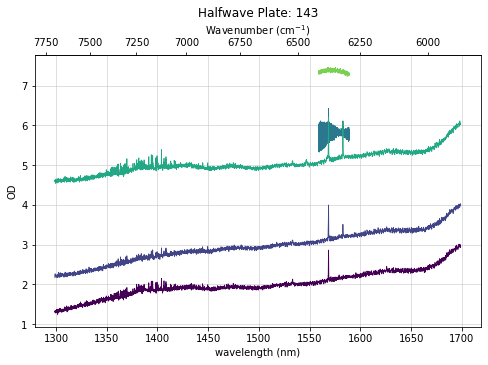

In [13]:
folder_list, file_list = sf.dir_interogate(path, exts, exceptions)
path_names = sf.read_files(folder_list, file_list)
ref_names, data_names = sf.search_paths(path_names, refs)
polarisations = sf.find_numbers(ref_names, tail=1)
ref_data, ref_metadata = sf.data_extract(ref_names, polarisations)
data_sets, metadata_sets = sf.data_extract(data_names, polarisations)
wave_sets, OD_sets = sf.OD_calc(ref_data, data_sets, correction=True, c_factor=1)
shifted_sets = sf.data_shift(wave_sets, calibration)
labels = 'wavelength (nm)', 'OD'
sf.plotter(shifted_sets, OD_sets, keys=polarisations, axis_lbls=labels, lims=None, shifter=1, woi=None, save=False, data_labels=folder_list)

In [ ]:
OD_smoothed = sf.smooth_data(OD_sets, 0.2)
sf.plotter(shifted_sets, OD_smoothed, keys=polarisations, axis_lbls=labels, lims=[550, 620], shifter=1, woi=None, save=False, data_labels=folder_list)

In [ ]:
peaks = sf.peak_find(OD_smoothed, args=[0.1, 0.1])
sf.plotter(x_data=wave_sets, y_data=OD_smoothed, data_indexes=peaks, keys=polarisations, axis_lbls=labels, shifter=1, lims=[570, 620])

In [ ]:
data_lists = peaks

data_set_lengths = [len(data_set_child) for data_set in data_lists for data_set_child in data_set]
lengths = [x for x in set(data_set_lengths)]
# if only one length all lengths are the same so boolean is True
if len(lengths) == 1:
    boolean = True
    indexes = None
else:
    boolean = False
    indexes = [[len(x) for x in data_set_child] for data_set_child in data_lists]

In [ ]:
len(file_list[0][0])

In [ ]:
diff = np.diff(roi_ODs[4][0], n=1)
diff_2 = np.diff(roi_ODs[4][0], n=2)
diff_3 = np.diff(roi_ODs[4][0], n=3)

mp.plot(diff)
#mp.plot(diff_2)
#mp.plot(diff_3)
mp.plot(roi_ODs[4][0])

In [ ]:
x =np.linspace(-100, 100, 10000)
amp_g = 40
amp_l = 20
y_0 = 0
x_0g = 1
x_0l = -1
sigma = 15
gamma = 40
eta = 0.8

gauss = sf.gaussian(x, amp_g, y_0, x_0g, sigma)
lorentz = sf.lorentzian(x, amp_l, y_0, x_0l, gamma)
noise = np.random.normal(size=np.size(gauss))

voigt = sf.pseudo_voigt(x, y_0, amp_g, x_0g, sigma, amp_l, x_0l, gamma, eta) + noise

mp.plot(x, gauss, 'r', label='gauss')
mp.plot(x, lorentz, 'b', label='lorentz')
mp.plot(x, voigt, 'orange', alpha=0.5, label='voigt')
mp.legend()

In [ ]:
fit_g = sf.fitgauss(x, voigt)
fit_l = sf.fitlorentz(x, voigt)
fit_v = sf.fitgls(x, voigt)

mp.plot(x, sf.lorentzian(x, *fit_l[0]), '--b', label='lorentz fit')
mp.plot(x, sf.gaussian(x, *fit_g[0]), '--g', label='gauss fit')
mp.plot(x, sf.pseudo_voigt(x, *fit_v[0]), '--r', label='voigt fit')
mp.plot(x, voigt, color='orange', alpha=0.5, label='noisey voigt')
mp.legend()